# Tensorflow MNIST Classifier demo

This notebook contains an end-to-end demostration of Dioptra that can be run on any modern laptop.
Please see the [example README](README.md) for instructions on how to prepare your environment for running this example.

### Setup

Below we import the necessary Python modules and ensure the proper environment variables are set so that all the code blocks will work as expected,

In [1]:
EXPERIMENT_NAME = "mnist_fgm"
EXPERIMENT_DESC = "applying the fast gradient sign (FGM) attack to a classifier trained on MNIST"
QUEUE_NAME = 'tensorflow_cpu'
QUEUE_DESC = 'Tensorflow CPU Queue'
MODEL_NAME = "mnist_classifier"

# Default address for accessing the RESTful API service
RESTAPI_ADDRESS = "http://localhost"

In [2]:
# Import packages from the Python standard library
import json
import os
import pprint
import time
import warnings
from IPython.display import display, clear_output
import logging
import structlog
from pathlib import Path

# Filter out warning messages
warnings.filterwarnings("ignore")
structlog.configure(
    wrapper_class=structlog.make_filtering_bound_logger(logging.ERROR),
)

from dioptra.client import connect_json_dioptra_client, connect_response_dioptra_client, select_files_in_directory, select_one_or_more_files

def wait_for_job(job, job_name, quiet=False):
    n = 0
    while job['status'] not in ['finished', 'failed']:
        job = client.jobs.get_by_id(job['id'])
        time.sleep(1)
        if not quiet:
            clear_output(wait=True)
            display("Waiting for job." + "." * (n % 3) )
        n += 1
    if not quiet:
        if job['status'] == 'finished':
            clear_output(wait=True)
            display(f'Job finished. Started "{job_name}" job.')
        else:
            raise Exception("Previous job failed. Please see tensorflow-cpu logs for details.")
    return job

### Dataset

We obtained a copy of the MNIST dataset when we ran `download_data.py` script. If you have not done so already, see [How to Obtain Common Datasets](https://pages.nist.gov/dioptra/getting-started/acquiring-datasets.html).
The training and testing images for the MNIST dataset are stored within the `/dioptra/data/Mnist` directory as PNG files that are organized into the following folder structure,

    Mnist
    ├── testing
    │   ├── 0
    │   ├── 1
    │   ├── 2
    │   ├── 3
    │   ├── 4
    │   ├── 5
    │   ├── 6
    │   ├── 7
    │   ├── 8
    │   └── 9
    └── training
        ├── 0
        ├── 1
        ├── 2
        ├── 3
        ├── 4
        ├── 5
        ├── 6
        ├── 7
        ├── 8
        └── 9

The subfolders under `training/` and `testing/` are the classification labels for the images in the dataset.
This folder structure is a standardized way to encode the label information and many libraries can make use of it, including the Tensorflow library that we are using for this particular demo.

### Login to Dioptra and setup RESTAPI client

To connect with the endpoint, we will use a client class defined in the `examples/scripts/client.py` file that is able to connect with the Dioptra RESTful API using the HTTP protocol.
We connect using the client below.
The client uses the environment variable `DIOPTRA_RESTAPI_URI`, which we configured at the top of the notebook, to figure out how to connect to the Dioptra RESTful API.

In [3]:
#client = connect_response_dioptra_client()
client = connect_json_dioptra_client(address=RESTAPI_ADDRESS)

It is necessary to login to the RESTAPI to be able to perform any functions. Here we create a user if it is not created already, and login with it.

In [4]:
try:
    client.users.create(
        username='pluginuser2',
        email='pluginuser2@dioptra.nccoe.nist.gov',
        password='pleasemakesuretoPLUGINthecomputer'
    )
except:
    pass # ignore if user exists already

client.auth.login(
    username='pluginuser2',
    password='pleasemakesuretoPLUGINthecomputer'
)


{'username': 'pluginuser2', 'status': 'Login successful'}

### Upload all the entrypoints in the src/ folder

In [5]:
# import from local filesystem

response = client.workflows.import_resources(group_id=1,
                                             source=select_files_in_directory("../extra/", recursive=True),
                                             config_path="dioptra.toml",
                                             resolve_name_conflicts_strategy="overwrite",
                                            )
resources = response["resources"]

train_ep = resources["entrypoints"]["Train"]
fgm_ep = resources["entrypoints"]["FGM"]
patch_gen_ep = resources["entrypoints"]["Patch Generation"]
patch_apply_ep = resources["entrypoints"]["Patch Application"]
predict_ep = resources["entrypoints"]["Predict"]
metrics_ep = resources["entrypoints"]["Metrics"]
defense_ep = resources["entrypoints"]["Defense"]

entrypoints = [train_ep, fgm_ep, patch_gen_ep, patch_apply_ep, predict_ep, metrics_ep, defense_ep]

In [6]:
logging.basicConfig(level=logging.ERROR) # Sets the root logger level

In [7]:
try:
    experiment = client.experiments.create(group_id=1, name=EXPERIMENT_NAME, description=EXPERIMENT_DESC)
except:
    experiment = client.experiments.get(search=f"name:'{EXPERIMENT_NAME}'")["data"][0]

try:
    queue = client.queues.create(group_id=1, name=QUEUE_NAME, description=QUEUE_DESC)
except:
    queue = client.queues.get(search=f"name:'{QUEUE_NAME}'")["data"][0]

experiment_id = experiment['id']
queue_id = queue['id']

client.experiments.entrypoints.create(experiment_id=experiment_id, entrypoint_ids=entrypoints)

for entrypoint in entrypoints:
    client.entrypoints.queues.create(entrypoint_id=entrypoint, queue_ids=[queue_id])

### Train a new le_net model on MNIST

In [8]:
job_time_limit = '1h'

training_job = client.experiments.jobs.create(
    experiment_id=experiment_id, 
    description=f"training", 
    queue_id=queue_id,
    entrypoint_id=train_ep, 
    values={"epochs":"3"}, 
    timeout=job_time_limit
)

This is a helper function to retrieve artifact IDs from dioptra by name for a given job. In this notebook it will be used to retrieve adversarial and defended datasets, as well as the model. In the future, it may not be used for the model, as that functionality receives more specific support in Dioptra.

In [9]:
def find_artifact_by_name(artifact_name, job):
    job = wait_for_job(job, "", quiet=True)
    for job_artifact in job["artifacts"]:
        artifact = client.artifacts.get_by_id(job_artifact["id"])
        if Path(artifact["artifactUri"]).name == artifact_name:
            return {
                "id": artifact["id"],
                "snapshotId": artifact["snapshot"],
            }
    raise Exception("Could not retrieve artifact")


### Generate adversarial examples using FGM attack

In [10]:
job_time_limit = '1h'

training_job = wait_for_job(training_job, 'fgm')
fgm_job = client.experiments.jobs.create(
    experiment_id=experiment_id,
    description=f"fgm",
    queue_id=queue_id,
    entrypoint_id=fgm_ep,
    values={"model_name": MODEL_NAME, "model_version": str(-1)}, # -1 means get the latest model
    artifact_values={
        "model_file": find_artifact_by_name("model.keras", training_job)
    },
    timeout=job_time_limit
)

'Job finished. Started "fgm" job.'

### Generate patches based on the model and dataset

In [11]:
job_time_limit = '1h'

wait_for_job(training_job, 'patch_gen')
patch_gen_job = client.experiments.jobs.create(
    experiment_id=experiment_id,
    description=f"patch generation",
    queue_id=queue_id,
    entrypoint_id=patch_gen_ep,
    values={
     "model_name": MODEL_NAME,
     "model_version": str(-1), # -1 means get the latest
     "rotation_max": str(180),
     "learning_rate": .1,
     "max_iter": str(500),
     "learning_rate": str(5.0),
    },
    artifact_values={
        "model_file": find_artifact_by_name("model.keras", training_job)
    },

    timeout=job_time_limit
)

'Job finished. Started "patch_gen" job.'

### Generate adversarial examples by attaching generated patches to the testing data

In [12]:
job_time_limit = '1h'

training_job = wait_for_job(training_job, 'patch_apply')
patch_gen_job = wait_for_job(patch_gen_job, 'patch_apply')
patch_apply_job = client.experiments.jobs.create(
    experiment_id=experiment_id,
    description=f"patch application",
    queue_id=queue_id,
    entrypoint_id=patch_apply_ep,
    values={
     "model_name": MODEL_NAME, 
     "model_version": str(-1), # -1 means get the latest model
     "patch_scale": str(0.5),
     "rotation_max": str(180),
    }, 
    artifact_values={
        "patch": find_artifact_by_name("patch.tar", patch_gen_job),
        "model_file": find_artifact_by_name("model.keras", training_job)
    },

    timeout=job_time_limit
)

'Job finished. Started "patch_apply" job.'

### Helper functions to submit defense/prediction/metrics jobs

In [13]:
def run_job(
    experiment_id: int,
    queue_id: int,
    entrypoint: dict[str, any], 
    description: str,
    previous_job: dict[str, any] = None, 
    model_name: str = None,
    model_version: int = -1,
    args: dict[str, any] = None, 
    artifacts: dict[str, any] = None, 
    job_time_limit: str = '1h'
):
    args = {} if args is None else args
    artifacts = {} if artifacts is None else artifacts

    if previous_job is not None:
        previous_job = wait_for_job(previous_job, description, quiet=False)
    
    if model_name is not None:
        args['model_name'] = model_name 
        args['model_version'] = str(model_version)
    
    job = client.experiments.jobs.create(
        experiment_id=experiment_id,
        description=description,
        queue_id=queue_id,
        entrypoint_id=entrypoint,
        values=args,
        artifact_values=artifacts,
        timeout=job_time_limit
    )
    
    return job


def defend(
    experiment_id: int, 
    queue_id: int, 
    defense_entrypoint: dict[str, any], 
    previous_job: dict[str, any],
    training_job: dict[str, any],
    artifact_name: str,
    defense: str = "spatial_smoothing", 
    defense_kwargs: dict[str, any] = None, 
    job_time_limit: str = '1h'
):
    defense_kwargs = {} if defense_kwargs is None else defense_kwargs

    arg_dict = {
        "def_type":defense,
        "defense_kwargs": json.dumps(defense_kwargs)
    }

    artifacts = {
        "adversarial_dataset" : find_artifact_by_name(artifact_name, previous_job),
        "model_file": find_artifact_by_name("model.keras", training_job)
    }

    previous_job_name = previous_job["description"]
    
    defense_job = run_job(
        experiment_id=experiment_id, 
        queue_id=queue_id, 
        entrypoint=defense_entrypoint, 
        description=f"{defense} defense against {previous_job_name}",
        previous_job=previous_job,
        args=arg_dict,
        artifacts=artifacts,
        job_time_limit=job_time_limit
    )
    
    return defense_job

def predict(
    experiment_id: int,
    queue_id: int,
    predict_entrypoint: dict[str, any],
    previous_job: dict[str, any],
    training_job: dict[str, any],
    artifact_name: str,
    job_time_limit='1h'
):
    artifacts = {
        "testing" : find_artifact_by_name(artifact_name, previous_job),
        "model_file": find_artifact_by_name("model.keras", training_job)
    }

    previous_job_name = previous_job["description"]
    
    predict_job = run_job(
        experiment_id=experiment_id, 
        queue_id=queue_id, 
        entrypoint=predict_entrypoint,
        description=f"prediction for {previous_job_name}",
        model_name=MODEL_NAME,
        artifacts=artifacts,
        previous_job=previous_job, 
        job_time_limit=job_time_limit
    )

    return predict_job

def measure(
    experiment_id: int, 
    queue_id: int, 
    measure_ep: dict[str, any], 
    previous_job: dict[str, any], 
    artifact_name: str = "predictions.csv",
    job_time_limit='1h'
):
    artifacts = {
        "predictions" : find_artifact_by_name(artifact_name, previous_job)
    }

    previous_job_name = previous_job["description"]
    
    metrics_job = run_job(
        experiment_id=experiment_id, 
        queue_id=queue_id, 
        entrypoint=measure_ep,
        previous_job=previous_job,
        description=f"metrics for {previous_job_name}",
        args={},
        artifacts=artifacts,
        job_time_limit=job_time_limit
    )
    
    return metrics_job

def get_metrics(job):
    wait_for_job(job, 'metrics', quiet=True)
    return client.jobs.get_metrics_by_id(job_id=job['id'])

### Base Accuracy against FGM without Defenses

In [14]:
predict_fgm = predict(experiment_id, queue_id, predict_ep, fgm_job, training_job, artifact_name="adversarial_dataset.tar")
measure_fgm = measure(experiment_id, queue_id, metrics_ep, predict_fgm)

'Job finished. Started "metrics for prediction for fgm" job.'

### Run Spatial Smoothing against FGM

In [15]:
spatial_job_fgm = defend(experiment_id, queue_id, defense_ep, fgm_job, training_job, artifact_name="adversarial_dataset.tar", defense="spatial_smoothing", defense_kwargs={
        "window_size": 7
    }
)

'Job finished. Started "spatial_smoothing defense against fgm" job.'

In [16]:
predict_spatial_fgm = predict(experiment_id, queue_id, predict_ep, spatial_job_fgm, training_job, artifact_name="defended_dataset.tar")
measure_spatial_fgm = measure(experiment_id, queue_id, metrics_ep, predict_spatial_fgm)

'Job finished. Started "metrics for prediction for spatial_smoothing defense against fgm" job.'

### Run JPEG Compression Defense against FGM

In [17]:
jpeg_comp_job_fgm = defend(experiment_id, queue_id, defense_ep, fgm_job, training_job, artifact_name="adversarial_dataset.tar", defense="jpeg_compression", defense_kwargs={
        "quality": 80,
    }
)

'Job finished. Started "jpeg_compression defense against fgm" job.'

In [18]:
predict_jpeg_comp_fgm = predict(experiment_id, queue_id, predict_ep, jpeg_comp_job_fgm, training_job, artifact_name="defended_dataset.tar")
measure_jpeg_comp_fgm = measure(experiment_id, queue_id, metrics_ep, predict_jpeg_comp_fgm)

'Job finished. Started "metrics for prediction for jpeg_compression defense against fgm" job.'

### Run Gaussian Defense against FGM

In [19]:
gaussian_job_fgm = defend(experiment_id, queue_id, defense_ep, fgm_job, training_job, artifact_name="adversarial_dataset.tar", defense="gaussian_augmentation", defense_kwargs={
        "augmentation": False,
        "ratio": 2,
        "sigma": .17,
        "apply_fit": False,
        "apply_predict": True
    }
)

'Job finished. Started "gaussian_augmentation defense against fgm" job.'

In [20]:
predict_gaussian_fgm = predict(experiment_id, queue_id, predict_ep, gaussian_job_fgm, training_job, artifact_name="defended_dataset.tar")
measure_gaussian_fgm = measure(experiment_id, queue_id, metrics_ep, predict_gaussian_fgm)

'Job finished. Started "metrics for prediction for gaussian_augmentation defense against fgm" job.'

### Base Accuracy against Patch Attack without Defenses

In [21]:
predict_patch = predict(experiment_id, queue_id, predict_ep, patch_apply_job, training_job, artifact_name="adversarial_dataset.tar")
measure_patch = measure(experiment_id, queue_id, metrics_ep, predict_patch)

'Job finished. Started "metrics for prediction for patch application" job.'

### Run Spatial Smoothing against Patch Attack

In [22]:
spatial_job_patch = defend(experiment_id, queue_id, defense_ep, patch_apply_job, training_job, artifact_name="adversarial_dataset.tar", defense="spatial_smoothing", defense_kwargs={
        "window_size": 3
    }
)

'Job finished. Started "spatial_smoothing defense against patch application" job.'

In [23]:
predict_spatial_patch = predict(experiment_id, queue_id, predict_ep, spatial_job_patch, training_job, artifact_name="defended_dataset.tar")
measure_spatial_patch = measure(experiment_id, queue_id, metrics_ep, predict_spatial_patch)

'Job finished. Started "metrics for prediction for spatial_smoothing defense against patch application" job.'

### Run JPEG Compression against Patch Attack

In [24]:
jpeg_comp_job_patch = defend(experiment_id, queue_id, defense_ep, patch_apply_job, training_job, artifact_name="adversarial_dataset.tar", defense="jpeg_compression", defense_kwargs={
        "quality": 95
    }
)

'Job finished. Started "jpeg_compression defense against patch application" job.'

In [25]:
predict_jpeg_comp_patch = predict(experiment_id, queue_id, predict_ep, jpeg_comp_job_patch, training_job, artifact_name="defended_dataset.tar")
measure_jpeg_comp_patch = measure(experiment_id, queue_id, metrics_ep, predict_jpeg_comp_patch)

'Job finished. Started "metrics for prediction for jpeg_compression defense against patch application" job.'

### Run Gaussian Defense against Patch Attack

In [26]:
gaussian_job_patch = defend(experiment_id, queue_id, defense_ep, patch_apply_job, training_job, artifact_name="adversarial_dataset.tar", defense="gaussian_augmentation", defense_kwargs={
        "augmentation": False,
        "ratio": 1,
        "sigma": .05,
        "apply_fit": False,
        "apply_predict": True
    }
)

'Job finished. Started "gaussian_augmentation defense against patch application" job.'

In [27]:
predict_gaussian_patch = predict(experiment_id, queue_id, predict_ep, gaussian_job_patch, training_job, artifact_name="defended_dataset.tar")
measure_gaussian_patch = measure(experiment_id, queue_id, metrics_ep, predict_gaussian_patch)

'Job finished. Started "metrics for prediction for gaussian_augmentation defense against patch application" job.'

### Retrieve and Display Metrics from Dioptra

In [28]:
import pprint

metrics = {
    "trained": get_metrics(training_job),
    "fgm": get_metrics(measure_fgm),
    "patch": get_metrics(measure_patch),
    "jpeg_fgm": get_metrics(measure_jpeg_comp_fgm),
    "spatial_fgm": get_metrics(measure_spatial_fgm),
    "gaussian_fgm": get_metrics(measure_gaussian_fgm),
    "jpeg_patch": get_metrics(measure_jpeg_comp_patch),
    "spatial_patch": get_metrics(measure_spatial_patch),
    "gaussian_patch": get_metrics(measure_gaussian_patch)
}

pp = pprint.PrettyPrinter(depth=4)
pp.pprint(metrics)

{'fgm': [{'name': 'accuracy', 'value': 0.2737},
         {'name': 'roc_auc', 'value': 0.5954665380300543}],
 'gaussian_fgm': [{'name': 'accuracy', 'value': 0.2914},
                  {'name': 'roc_auc', 'value': 0.6059775022768082}],
 'gaussian_patch': [{'name': 'accuracy', 'value': 0.7991},
                    {'name': 'roc_auc', 'value': 0.8895618424482026}],
 'jpeg_fgm': [{'name': 'accuracy', 'value': 0.2815},
              {'name': 'roc_auc', 'value': 0.5996947956829995}],
 'jpeg_patch': [{'name': 'accuracy', 'value': 0.8011},
                {'name': 'roc_auc', 'value': 0.8906833882674116}],
 'patch': [{'name': 'accuracy', 'value': 0.8029},
           {'name': 'roc_auc', 'value': 0.8916785654935147}],
 'spatial_fgm': [{'name': 'accuracy', 'value': 0.4167},
                 {'name': 'roc_auc', 'value': 0.6722096162426207}],
 'spatial_patch': [{'name': 'roc_auc', 'value': 0.8701866041592599},
                   {'name': 'accuracy', 'value': 0.7651}],
 'trained': [{'name': 'training_

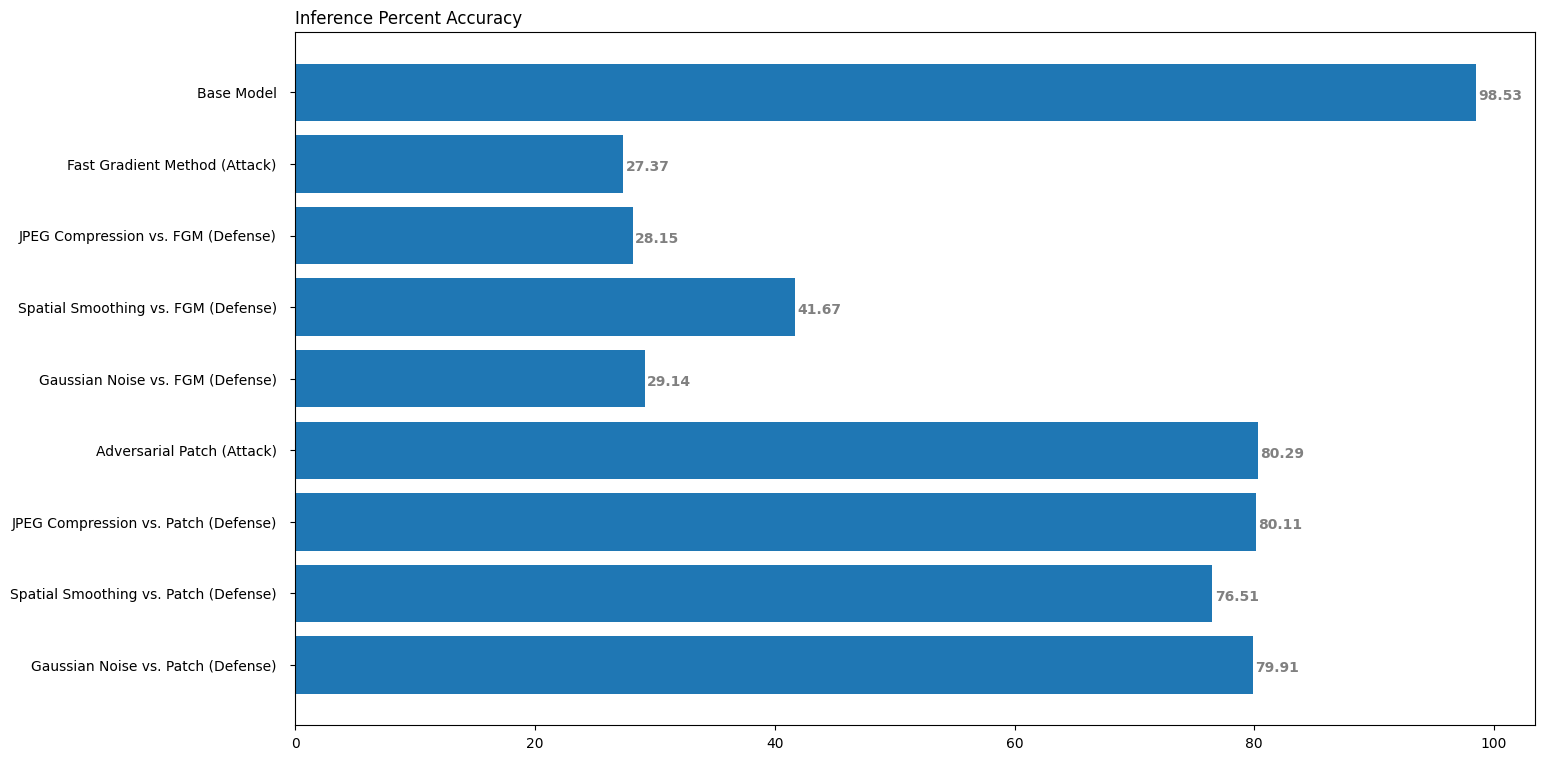

In [29]:
import numpy as np
import matplotlib.pyplot as plt 

scenarios = {
    'trained': 'Base Model',
    'fgm': 'Fast Gradient Method (Attack)',
    'jpeg_fgm': 'JPEG Compression vs. FGM (Defense)',
    'spatial_fgm': 'Spatial Smoothing vs. FGM (Defense)',
    'gaussian_fgm': 'Gaussian Noise vs. FGM (Defense)',
    'patch': 'Adversarial Patch (Attack)',
    'jpeg_patch': 'JPEG Compression vs. Patch (Defense)',
    'spatial_patch': 'Spatial Smoothing vs. Patch (Defense)',
    'gaussian_patch': 'Gaussian Noise vs. Patch (Defense)'
}
names = [scenarios[k] for k in scenarios.keys()]
values = [[job_metric['value'] * 100 for job_metric in metrics[k] if job_metric['name'] == 'accuracy'][0] for k in scenarios.keys()]

fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(names, values)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Show top values 
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Inference Percent Accuracy',
             loc ='left', )

# Show Plot
plt.show()